# Assignment #4

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os

torch.__version__

'1.2.0'

In [2]:
transform = transforms.Compose([#transforms.Resize((1,10000)),
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = '..\\Assignment#2\\horse-or-human\\train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# print(trainset)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=False, num_workers=1)  


validation_data_path = '..\\Assignment#2\\horse-or-human\\validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=1, shuffle=False, num_workers=1)  

In [3]:
train_data = np.zeros((10000, 0))
train_label = np.zeros((0,1))
val_data = np.zeros((10000,0))
val_label = np.zeros((0,1))

# load training images of the batch size for every iteration
for i, data in enumerate(trainloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data
    
    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    train_data = np.hstack((train_data, np.reshape(inputs, (10000,1))))
    
    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    train_label = np.append(train_label, labels)

train_label = train_label.reshape(1,1027)


# load validation images of the batch size for every iteration
for i, data in enumerate(valloader):

    # inputs is the image
    # labels is the class of the image
    inputs, labels = data

    # if you don't change the image size, it will be [batch_size, 1, 100, 100]
    val_data = np.hstack((val_data, np.reshape(inputs, (10000,1))))

    # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
    val_label = np.append(val_label, labels)

val_label = val_label.reshape(1,256)


print("train_label shape : " + str(train_label.shape))
print("train_data shape  : " + str(train_data.shape))
print("val_label shape   : " + str(val_label.shape))
print("val_label shape   : " + str(val_data.shape))

train_label shape : (1, 1027)
train_data shape  : (10000, 1027)
val_label shape   : (1, 256)
val_label shape   : (10000, 256)


In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def ReLU(z):
    return np.maximum(0, z)

def LeakyReLU(z, a):
    return np.maximum(a*z, z)

### $ g^{[1]}, g^{[2]}, g^{[3]} $ are Sigmoid (from the previous assignment)

In [5]:
# INITIALIZE VARIABLES, EPOCH, LEARNING RATE, NUMBER OF NODES IN HIDDEN LAYER
LEARNING_RATE = 0.005
NUM_EPOCH = 25000
NUM_HIDDEN_LAYER_1 = 5
NUM_HIDDEN_LAYER_2 = 3
EPSILON = 0.00000000001

NUM_TRAIN_DATA = train_data.shape[1]
NUM_VAL_DATA = val_data.shape[1]
IMAGE_VECTOR_LEN = train_data.shape[0]

w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

sig_train_loss = np.zeros((2,NUM_EPOCH))
sig_train_accuracy = np.zeros((2,NUM_EPOCH))
sig_val_loss = np.zeros((2,NUM_EPOCH))
sig_val_accuracy = np.zeros((2,NUM_EPOCH))

In [6]:
prev_loss = 0
loss = 0

for i in range(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) *  (1 - A_2) * A_2
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * (1 - A_1) * A_1
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE * dw_1
    w_2 = w_2 - LEARNING_RATE * dw_2
    w_3 = w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    sig_train_loss[0][i] = i+1
    sig_train_loss[1][i] = J
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    sig_train_accuracy[0][i] = i+1
    sig_train_accuracy[1][i] = correct/NUM_TRAIN_DATA
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = sigmoid(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = sigmoid(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    sig_val_loss[0][i] = i+1
    sig_val_loss[1][i] = J
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    sig_val_accuracy[0][i] = i+1
    sig_val_accuracy[1][i] = correct/NUM_VAL_DATA
    
    if abs(loss - prev_loss) < EPSILON :
        print("Train loss converged at Epoch " + str(i+1))
        break
    prev_loss = loss 
    
    if((i+1) % 1000 == 0):
        print("Epoch " + str(i+1) + " Done")

Epoch 1000 Done
Epoch 2000 Done
Epoch 3000 Done
Epoch 4000 Done
Epoch 5000 Done
Epoch 6000 Done
Epoch 7000 Done
Epoch 8000 Done
Epoch 9000 Done
Epoch 10000 Done
Epoch 11000 Done
Epoch 12000 Done
Epoch 13000 Done
Epoch 14000 Done
Epoch 15000 Done
Epoch 16000 Done
Epoch 17000 Done
Epoch 18000 Done
Epoch 19000 Done
Epoch 20000 Done
Epoch 21000 Done
Epoch 22000 Done
Epoch 23000 Done
Epoch 24000 Done
Epoch 25000 Done


In [7]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
temp = sig_val_accuracy[1][0]
index = sig_val_accuracy[0][0]
for x in range(NUM_EPOCH):
    if temp < sig_val_accuracy[1][x]:
        temp = sig_val_accuracy[1][x]
        index = sig_val_accuracy[0][x]

index = int(index)

print("Train_Loss     : " + str(sig_train_loss[1][index-1]))
print("Train_Accuracy : " + str(sig_train_accuracy[1][index-1]))
print("Val_Loss       : " + str(sig_val_loss[1][index-1]))
print("Val_Accuracy   : " + str(sig_val_accuracy[1][index-1]))

Train_Loss     : 0.6932424653594995
Train_Accuracy : 0.48685491723466406
Val_Loss       : 0.6931509398827187
Val_Accuracy   : 0.5


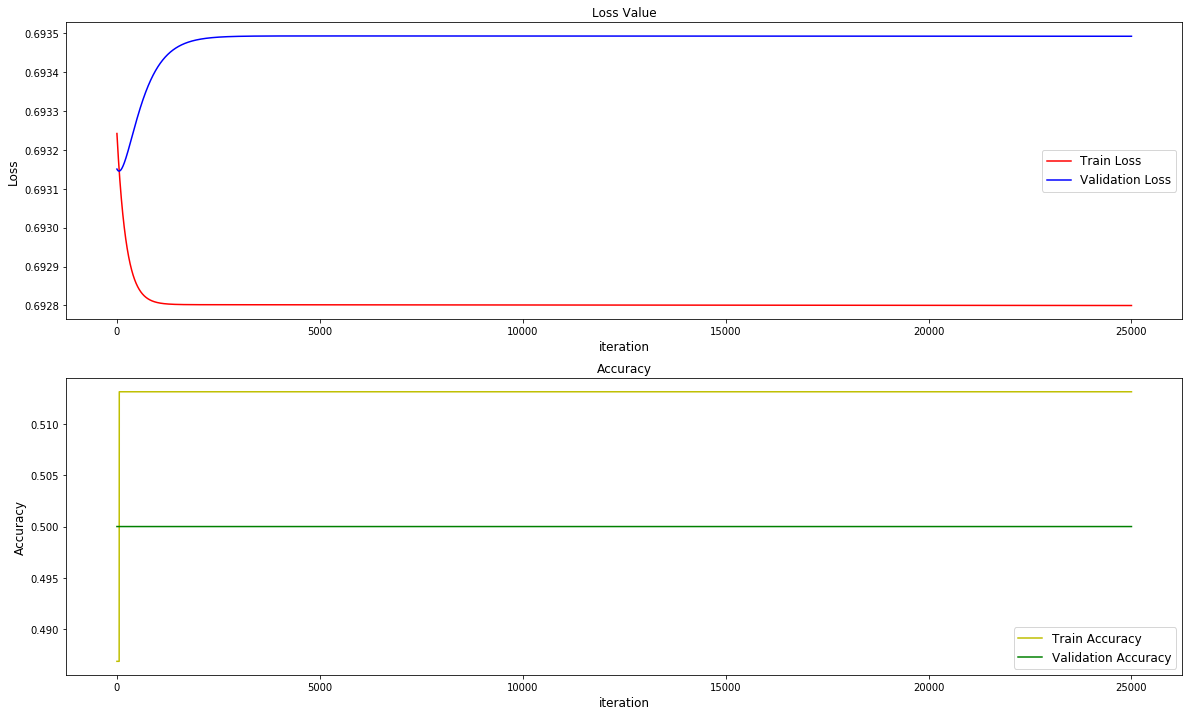

In [8]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(sig_train_loss[0], sig_train_loss[1],'-r', label='Train Loss')
ax2[0].plot(sig_val_loss[0], sig_val_loss[1], '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(sig_train_accuracy[0], sig_train_accuracy[1], '-y', label='Train Accuracy')
ax2[1].plot(sig_val_accuracy[0], sig_val_accuracy[1], '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when  $ g^{[1]}, g^{[2]}, g^{[3]} $ are Sigmoid (from the previous assignment)

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| {{sig_train_loss[1][index-1]}} | |
|Validation| | |

### $ g^{[1]}, g^{[2]} $ are tanh and $ g^{[3]} $ is Sigmoid

In [9]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

tanh_train_loss = np.zeros((2,NUM_EPOCH))
tanh_train_accuracy = np.zeros((2,NUM_EPOCH))
tanh_val_loss = np.zeros((2,NUM_EPOCH))
tanh_val_accuracy = np.zeros((2,NUM_EPOCH))

In [10]:
prev_loss = 0
loss = 0

for i in range(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3) *(1 - A_2) * (1 + A_2)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2) * (1 - A_1) * (1 + A_1)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE * dw_1
    w_2 = w_2 - LEARNING_RATE * dw_2
    w_3 = w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    tanh_train_loss[0][i] = i+1
    tanh_train_loss[1][i] = J
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    tanh_train_accuracy[0][i] = i+1
    tanh_train_accuracy[1][i] = correct/NUM_TRAIN_DATA
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = tanh(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = tanh(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    tanh_val_loss[0][i] = i+1
    tanh_val_loss[1][i] = J
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    tanh_val_accuracy[0][i] = i+1
    tanh_val_accuracy[1][i] = correct/NUM_VAL_DATA
    
    if abs(loss - prev_loss) < EPSILON :
        print("Train loss converged at Epoch " + str(i+1))
        break
    prev_loss = loss 
    
    if((i+1) % 1000 == 0):
        print("Epoch " + str(i+1) + " Done")

Epoch 1000 Done
Epoch 2000 Done
Epoch 3000 Done
Epoch 4000 Done
Epoch 5000 Done
Epoch 6000 Done
Epoch 7000 Done
Epoch 8000 Done
Epoch 9000 Done
Epoch 10000 Done
Epoch 11000 Done
Epoch 12000 Done
Epoch 13000 Done
Epoch 14000 Done
Epoch 15000 Done
Epoch 16000 Done
Epoch 17000 Done
Epoch 18000 Done
Epoch 19000 Done
Epoch 20000 Done
Epoch 21000 Done
Epoch 22000 Done
Epoch 23000 Done
Epoch 24000 Done
Epoch 25000 Done


In [11]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
temp = tanh_val_accuracy[1][0]
index = tanh_val_accuracy[0][0]
for x in range(NUM_EPOCH):
    if temp < tanh_val_accuracy[1][x]:
        temp = tanh_val_accuracy[1][x]
        index = tanh_val_accuracy[0][x]

index = int(index)

print("Train_Loss     : " + str(tanh_train_loss[1][index-1]))
print("Train_Accuracy : " + str(tanh_train_accuracy[1][index-1]))
print("Val_Loss       : " + str(tanh_val_loss[1][index-1]))
print("Val_Accuracy   : " + str(tanh_val_accuracy[1][index-1]))

Train_Loss     : 0.3521485915679463
Train_Accuracy : 0.8880233690360273
Val_Loss       : 0.3449637245942577
Val_Accuracy   : 0.890625


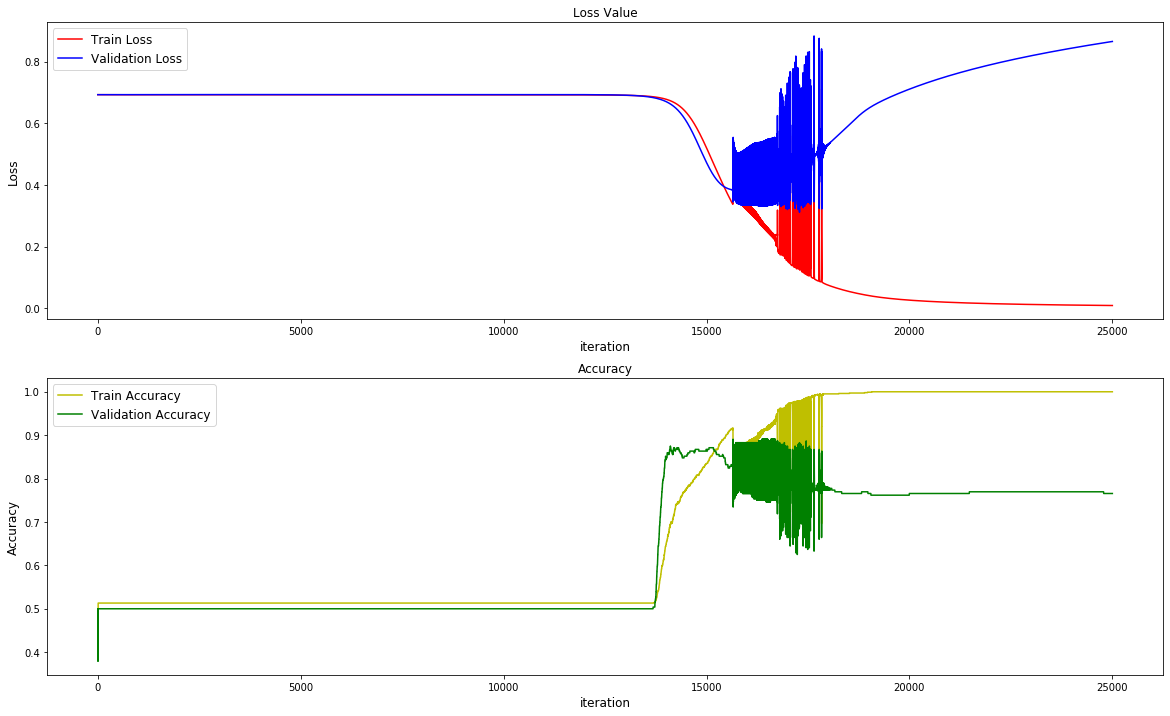

In [12]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(tanh_train_loss[0], tanh_train_loss[1],'-r', label='Train Loss')
ax2[0].plot(tanh_val_loss[0], tanh_val_loss[1], '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(tanh_train_accuracy[0], tanh_train_accuracy[1], '-y', label='Train Accuracy')
ax2[1].plot(tanh_val_accuracy[0], tanh_val_accuracy[1], '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are tanh and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| | |
|Validation| | |

## $ g^{[1]}, g^{[2]} $ are ReLU and $ g^{[3]} $ is Sigmoid

In [13]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

relu_train_loss = np.zeros((2,NUM_EPOCH))
relu_train_accuracy = np.zeros((2,NUM_EPOCH))
relu_val_loss = np.zeros((2,NUM_EPOCH))
relu_val_accuracy = np.zeros((2,NUM_EPOCH))

In [14]:
prev_loss = 0
loss = 0

for i in range(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = ReLU(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = ReLU(z_2)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = (np.dot(w_3.T, dz_3) > 0).astype(int)
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = (np.dot(w_2.T, dz_2) > 0).astype(int)
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE * dw_1
    w_2 = w_2 - LEARNING_RATE * dw_2
    w_3 = w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    relu_train_loss[0][i] = i+1
    relu_train_loss[1][i] = J
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    relu_train_accuracy[0][i] = i+1
    relu_train_accuracy[1][i] = correct/NUM_TRAIN_DATA
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = ReLU(z_1)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = ReLU(z_2)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    relu_val_loss[0][i] = i+1
    relu_val_loss[1][i] = J
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    relu_val_accuracy[0][i] = i+1
    relu_val_accuracy[1][i] = correct/NUM_VAL_DATA
    
#     if abs(loss - prev_loss) < EPSILON * 0.000000001 :
#         print("Train loss converged at Epoch " + str(i+1))
#         break
#     prev_loss = loss 
    
    if((i+1) % 1000 == 0):
        print("Epoch " + str(i+1) + " Done")

Epoch 1000 Done
Epoch 2000 Done
Epoch 3000 Done
Epoch 4000 Done
Epoch 5000 Done
Epoch 6000 Done
Epoch 7000 Done
Epoch 8000 Done
Epoch 9000 Done
Epoch 10000 Done
Epoch 11000 Done
Epoch 12000 Done
Epoch 13000 Done
Epoch 14000 Done
Epoch 15000 Done
Epoch 16000 Done
Epoch 17000 Done
Epoch 18000 Done
Epoch 19000 Done
Epoch 20000 Done
Epoch 21000 Done
Epoch 22000 Done
Epoch 23000 Done
Epoch 24000 Done
Epoch 25000 Done


In [15]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
temp = relu_val_accuracy[1][0]
index = relu_val_accuracy[0][0]
for x in range(NUM_EPOCH):
    if temp < relu_val_accuracy[1][x]:
        temp = relu_val_accuracy[1][x]
        index = relu_val_accuracy[0][x]

index = int(index)

print("Train_Loss     : " + str(relu_train_loss[1][index-1]))
print("Train_Accuracy : " + str(relu_train_accuracy[1][index-1]))
print("Val_Loss       : " + str(relu_val_loss[1][index-1]))
print("Val_Accuracy   : " + str(relu_val_accuracy[1][index-1]))

Train_Loss     : 0.6931484129313532
Train_Accuracy : 0.4819863680623174
Val_Loss       : 0.6931474979886574
Val_Accuracy   : 0.5


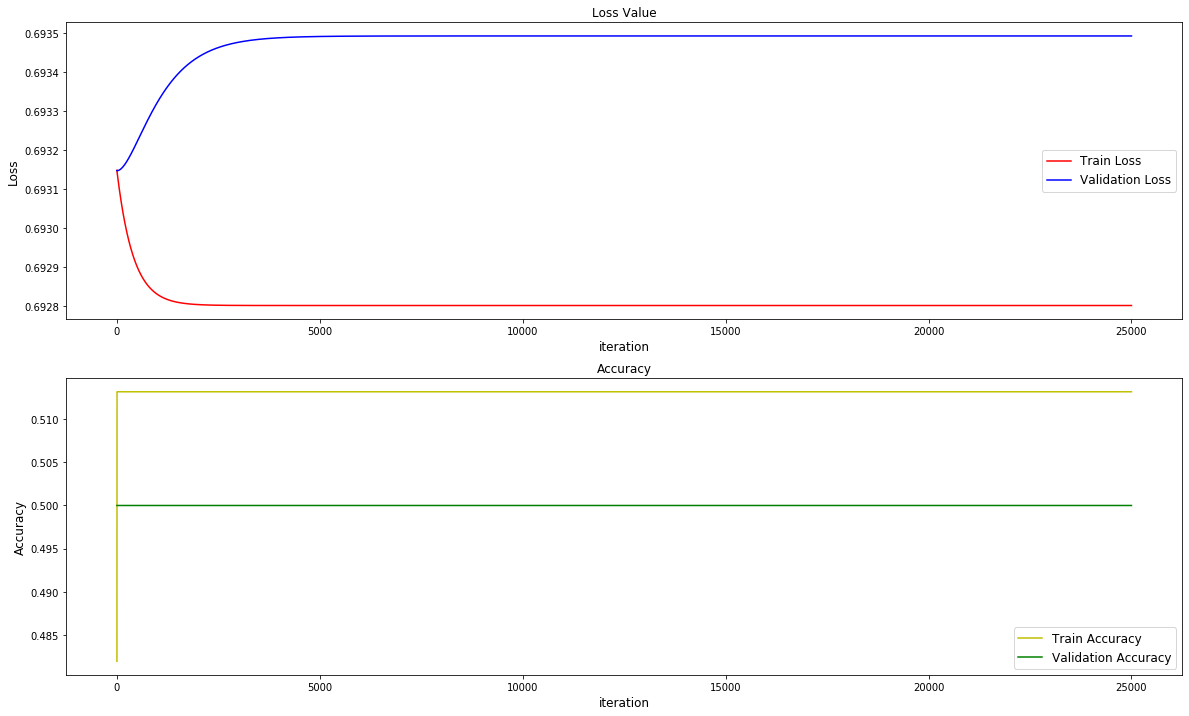

In [16]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(relu_train_loss[0], relu_train_loss[1],'-r', label='Train Loss')
ax2[0].plot(relu_val_loss[0], relu_val_loss[1], '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(relu_train_accuracy[0], relu_train_accuracy[1], '-y', label='Train Accuracy')
ax2[1].plot(relu_val_accuracy[0], relu_val_accuracy[1], '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are ReLU and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| | |
|Validation| | |

## $ g^{[1]}, g^{[2]} $ are Leaky ReLU with your choice of $ \alpha $ and $ g^{[3]} $ is Sigmoid

In [17]:
w_1 = np.random.randn(NUM_HIDDEN_LAYER_1,10000) * 0.01
w_2 = np.random.randn(NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1) * 0.01
w_3 = np.random.randn(1, NUM_HIDDEN_LAYER_2) * 0.01

b_1 = 0
b_2 = 0
b_3 = 0

leaky_train_loss = np.zeros((2,NUM_EPOCH))
leaky_train_accuracy = np.zeros((2,NUM_EPOCH))
leaky_val_loss = np.zeros((2,NUM_EPOCH))
leaky_val_accuracy = np.zeros((2,NUM_EPOCH))

ALPHA = 0.05

In [18]:
prev_loss = 0
loss = 0

for i in range(NUM_EPOCH):
    J = 0   
    dw_1 = np.zeros((NUM_HIDDEN_LAYER_1, 10000))
    dw_2 = np.zeros((NUM_HIDDEN_LAYER_2, NUM_HIDDEN_LAYER_1))
    dw_3 = np.zeros((1, NUM_HIDDEN_LAYER_2))
    
    db_1 = 0
    db_2 = 0
    db_3 = 0
    
    dz_1 = 0
    dz_2 = 0
    dz_3 = 0
    
    # COMPUTATION OF THE GRADIENT AND UPDATE OF MODEL PARAMETERS
    z_1 = np.dot(w_1, train_data) + b_1
    A_1 = LeakyReLU(z_1, ALPHA)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = LeakyReLU(z_2, ALPHA)

    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)

    # COMPUTAION OF DERIVATIVES
    dz_3 = A_3 - train_label
    dw_3 = np.dot(dz_3, A_2.T) / NUM_TRAIN_DATA
    db_3 = np.sum(dz_3, axis=1, keepdims=True) / NUM_TRAIN_DATA

    dz_2 = np.dot(w_3.T, dz_3)
    dz_2[dz_2 > 0] = 1
    dz_2[dz_2 <= 0] = ALPHA
    
    dw_2 = np.dot(dz_2, A_1.T) / NUM_TRAIN_DATA
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    dz_1 = np.dot(w_2.T, dz_2)
    dz_1[dz_1 > 0] = 1
    dz_1[dz_1 <= 0] = ALPHA
    
    dw_1 = np.dot(dz_1, train_data.T) / NUM_TRAIN_DATA
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / NUM_TRAIN_DATA
    
    # UPDATE PARAMETERS
    w_1 = w_1 - LEARNING_RATE * dw_1
    w_2 = w_2 - LEARNING_RATE * dw_2
    w_3 = w_3 - LEARNING_RATE * dw_3
    
    b_1 = b_1 - LEARNING_RATE * db_1
    b_2 = b_2 - LEARNING_RATE * db_2
    b_3 = b_3 - LEARNING_RATE * db_3
    
    
    # FOR CALCULATING TRAIN LOSS
    J = (np.dot(train_label, (np.log(A_3)).T) + np.dot(1-train_label, (np.log(1-A_3)).T))
    J = -np.sum(J) / NUM_TRAIN_DATA
    leaky_train_loss[0][i] = i+1
    leaky_train_loss[1][i] = J
    loss = J
    
    # FOR CALCULATING TRAIN ACCURACY
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_TRAIN_DATA):
        if A_3[0][x] == train_label[0][x]:
            correct += 1
        
    leaky_train_accuracy[0][i] = i+1
    leaky_train_accuracy[1][i] = correct/NUM_TRAIN_DATA
    
    # FOR CALCULATING VALIDATION LOSS   
    z_1 = np.dot(w_1, val_data) + b_1
    A_1 = LeakyReLU(z_1, ALPHA)
    
    z_2 = np.dot(w_2, A_1) + b_2
    A_2 = LeakyReLU(z_2, ALPHA)
    
    z_3 = np.dot(w_3, A_2) + b_3
    A_3 = sigmoid(z_3)
    
    J = (np.dot(val_label, (np.log(A_3)).T) + np.dot(1-val_label, (np.log(1-A_3)).T))
    J = -np.sum(J)/NUM_VAL_DATA
    leaky_val_loss[0][i] = i+1
    leaky_val_loss[1][i] = J
    
    # FOR CALCULATING VALIDATION ACCURACY
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] >= 0.5:
            A_3[0][x] = 1
        else:
            A_3[0][x] = 0
    
    correct = 0
    for x in range(NUM_VAL_DATA):
        if A_3[0][x] == val_label[0][x]:
            correct += 1
        
    leaky_val_accuracy[0][i] = i+1
    leaky_val_accuracy[1][i] = correct/NUM_VAL_DATA
    
    if abs(loss - prev_loss) < EPSILON :
        print("Train loss converged at Epoch " + str(i+1))
        break
    prev_loss = loss 
    
    if((i+1) % 1000 == 0):
        print("Epoch " + str(i+1) + " Done")

C:\Users\ddamddi\.conda\envs\ml-project\lib\site-packages\ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
C:\Users\ddamddi\.conda\envs\ml-project\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


Epoch 1000 Done
Epoch 2000 Done
Epoch 3000 Done
Epoch 4000 Done
Epoch 5000 Done
Epoch 6000 Done
Epoch 7000 Done
Epoch 8000 Done
Epoch 9000 Done
Epoch 10000 Done
Epoch 11000 Done
Epoch 12000 Done
Epoch 13000 Done
Epoch 14000 Done
Epoch 15000 Done
Epoch 16000 Done
Epoch 17000 Done
Epoch 18000 Done
Epoch 19000 Done
Epoch 20000 Done
Epoch 21000 Done
Epoch 22000 Done
Epoch 23000 Done
Epoch 24000 Done
Epoch 25000 Done


In [19]:
# FIND FINAL ACCURACY AND LOSS OF DATASETS
temp = leaky_val_accuracy[1][0]
index = leaky_val_accuracy[0][0]
for x in range(NUM_EPOCH):
    if temp < leaky_val_accuracy[1][x]:
        temp = leaky_val_accuracy[1][x]
        index = leaky_val_accuracy[0][x]

index = int(index)

print("Train_Loss     : " + str(leaky_train_loss[1][index-1]))
print("Train_Accuracy : " + str(leaky_train_accuracy[1][index-1]))
print("Val_Loss       : " + str(leaky_val_loss[1][index-1]))
print("Val_Accuracy   : " + str(leaky_val_accuracy[1][index-1]))

Train_Loss     : 0.6931459851202556
Train_Accuracy : 0.5443037974683544
Val_Loss       : 0.6931478119247789
Val_Accuracy   : 0.5


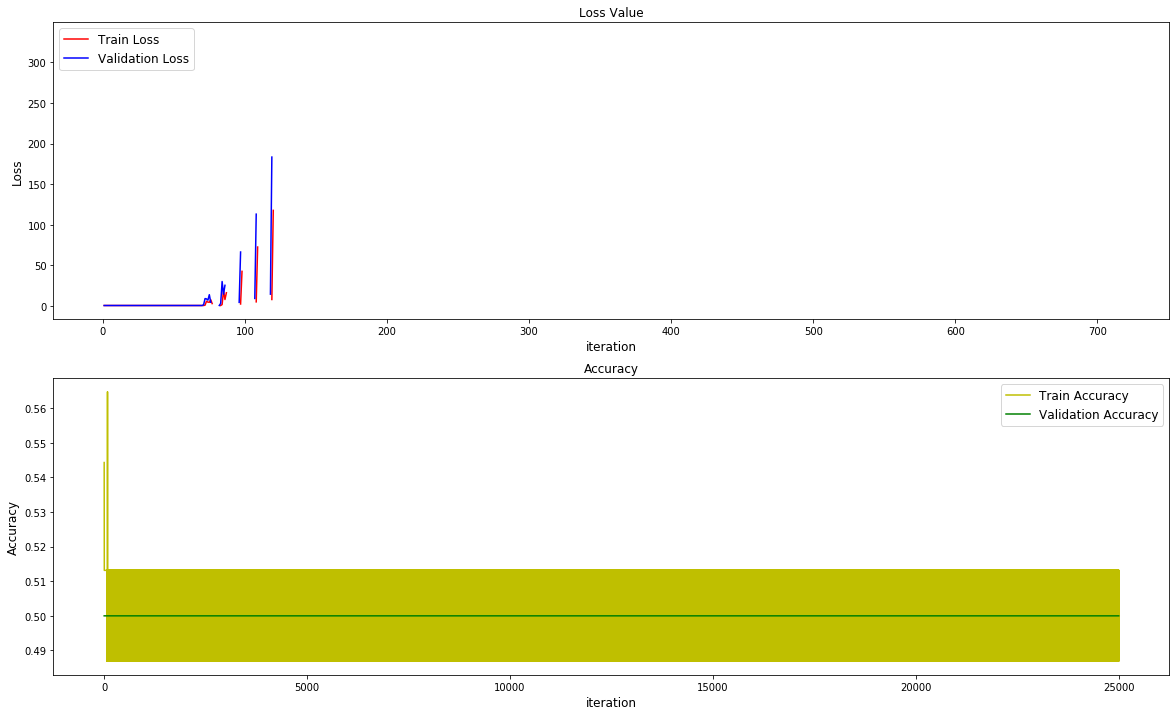

In [20]:
# PLOT TRAIN AND VALIDATION LOSS AT EVERY ITERATION
fig, ax2 = plt.subplots(2,1,figsize=(20,12))
ax2[0].set_title("Loss Value")
ax2[0].set_ylabel("Loss", fontsize="12")
ax2[0].set_xlabel("iteration", fontsize="12")
ax2[0].plot(leaky_train_loss[0], leaky_train_loss[1],'-r', label='Train Loss')
ax2[0].plot(leaky_val_loss[0], leaky_val_loss[1], '-b', label='Validation Loss')
ax2[0].legend(fontsize="12")

# PLOT TRAIN AND VALIDATION ACCURACY AT EVERY ITERATION
ax2[1].set_title("Accuracy")
ax2[1].set_ylabel("Accuracy", fontsize="12")
ax2[1].set_xlabel("iteration", fontsize="12")
ax2[1].plot(leaky_train_accuracy[0], leaky_train_accuracy[1], '-y', label='Train Accuracy')
ax2[1].plot(leaky_val_accuracy[0], leaky_val_accuracy[1], '-g', label='Validation Accuracy')
ax2[1].legend(fontsize="12")
plt.show()

### Result when $ g^{[1]}, g^{[2]} $ are Leaky ReLU with your choice of $ \alpha $ and $ g^{[3]} $ is Sigmoid

| Dataset | Loss | Accuracy |
|--|--|--|
|Train| | |
|Validation| | |

## Final Result

| Activation function | Train Loss | Train Accuarcy | Val. Loss | Val. Accuracy
| -- | -- | -- | -- | -- |
| ONLY sigmoid | | | | |
| tanh + sigmoid | | | | |
| ReLU + sigmoid | | | | |
| Leaky ReLU + sigmoid | | | | |